# Multuplicators. part 2

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
from sklearn import covariance
from sklearn import preprocessing

import datetime as dt
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

import pickle as pk
import requests

import random

jtplot.style(figsize=(15, 9))

In [2]:
data = pd.read_csv('../../data/sp500_Company_Overview.csv', index_col=0)
data.head()

,AssetType,Name,Description,CIK,Exchange,Currency,Country,Sector,Industry,Address,...,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,50DayMovingAverage,200DayMovingAverage,SharesOutstanding,DividendDate,ExDividendDate
Symbol,,,,,,,,,,,,,,,,,,,,,
MMM,Common Stock,3M Company,The 3M Company is an American multinational co...,66740.0,NYSE,USD,USA,LIFE SCIENCES,SURGICAL & MEDICAL INSTRUMENTS & APPARATUS,"3M CENTER, BLDG. 220-13E-26A, ST PAUL, MN, US",...,1.879,-9.08,1.001,105.52,68.63,101.50,98.13,5.533610e+08,2024-06-12,2024-05-23
AOS,Common Stock,Smith AO Corporation,A. O. Smith Corporation is an American manufac...,91142.0,NYSE,USD,USA,MANUFACTURING,HOUSEHOLD APPLIANCES,"11270 WEST PARK PLACE, MILWAUKEE, WI, US",...,3.248,15.19,1.141,92.44,63.34,83.92,81.37,1.207840e+08,2024-08-15,2024-07-31
ABT,Common Stock,Abbott Laboratories,Abbott Laboratories is an American multination...,1800.0,NYSE,USD,USA,LIFE SCIENCES,PHARMACEUTICAL PREPARATIONS,"100 ABBOTT PARK ROAD, ABBOTT PARK, IL, US",...,4.928,18.75,0.718,120.40,88.33,103.84,106.60,1.739630e+09,2024-08-15,2024-07-15
ABBV,Common Stock,AbbVie Inc,AbbVie is an American publicly traded biopharm...,1551152.0,NYSE,USD,USA,LIFE SCIENCES,PHARMACEUTICAL PREPARATIONS,"1 NORTH WAUKEGAN ROAD, NORTH CHICAGO, IL, US",...,6.15,19.45,0.623,179.55,132.11,166.45,162.53,1.765870e+09,2024-08-15,2024-07-15
ACN,Common Stock,Accenture plc,Accenture plc is an Irish-domiciled multinatio...,1467373.0,NYSE,USD,USA,TRADE & SERVICES,"SERVICES-BUSINESS SERVICES, NEC","1 GRAND CANAL SQUARE, GRAND CANAL HARBOUR, DUB...",...,3.041,18.21,1.227,384.33,277.47,301.44,329.36,6.263840e+08,2024-08-15,2024-07-11


In [3]:
data.drop(['AssetType',
           'CIK',
           'Exchange',
           'Description',
           'Currency',
           'Country',
           'Address',
           'DividendPerShare',
           'FiscalYearEnd',
           'LatestQuarter',
           'DividendDate',
           'ExDividendDate',
          ], inplace=True, axis=1)

In [4]:
data.replace('None', np.nan, inplace=True)

In [5]:
data['MarketCapitalization'] = data['MarketCapitalization'].astype(float)
data['Beta'] = data['Beta'].astype(float)
data['PEGRatio'] = data['PEGRatio'].astype(float)
data['PERatio'] = data['PERatio'].astype(float)
data['BookValue'] = data['BookValue'].astype(float)
data['DividendYield'] = data['DividendYield'].astype(float)
data['EPS'] = data['EPS'].astype(float)
data['RevenuePerShareTTM'] = data['RevenuePerShareTTM'].astype(float)
data['ProfitMargin'] = data['ProfitMargin'].astype(float)
data['OperatingMarginTTM'] = data['OperatingMarginTTM'].astype(float)
data['ReturnOnAssetsTTM'] = data['ReturnOnAssetsTTM'].astype(float)
data['EBITDA'] = data['EBITDA'].astype(float)
data['RevenueTTM'] = data['RevenueTTM'].astype(float)
data['GrossProfitTTM'] = data['GrossProfitTTM'].astype(float)
data['DilutedEPSTTM'] = data['DilutedEPSTTM'].astype(float)
data['QuarterlyEarningsGrowthYOY'] = data['QuarterlyEarningsGrowthYOY'].astype(float)
data['QuarterlyRevenueGrowthYOY'] = data['QuarterlyRevenueGrowthYOY'].astype(float)
data['52WeekHigh'] = data['52WeekHigh'].astype(float)
data['52WeekLow'] = data['52WeekLow'].astype(float)

In [6]:
sectors_sum = data.groupby('Sector').sum()

mc_norm = preprocessing.normalize(sectors_sum['MarketCapitalization'].to_numpy().reshape(1, -1))
eb_norm = preprocessing.normalize(sectors_sum['EBITDA'].to_numpy().reshape(1, -1))
rv_norm = preprocessing.normalize(sectors_sum['RevenueTTM'].to_numpy().reshape(1, -1))

df_norm = pd.DataFrame(index=sectors_sum.index, data={'MarketCapitalization': mc_norm.flatten(),
                                                      'EBITDA': eb_norm.flatten(),
                                                      'RevenueTTM': rv_norm.flatten(),
                                                     })

df_norm

,MarketCapitalization,EBITDA,RevenueTTM
Sector,,,
ENERGY & TRANSPORTATION,0.173454,0.397156,0.326386
FINANCE,0.257253,0.219505,0.413444
LIFE SCIENCES,0.268986,0.284324,0.197747
MANUFACTURING,0.418801,0.328870,0.345236
REAL ESTATE & CONSTRUCTION,0.063226,0.080128,0.049646
TECHNOLOGY,0.733547,0.694292,0.404125
TRADE & SERVICES,0.337488,0.341508,0.631240


<AxesSubplot:ylabel='Sector'>

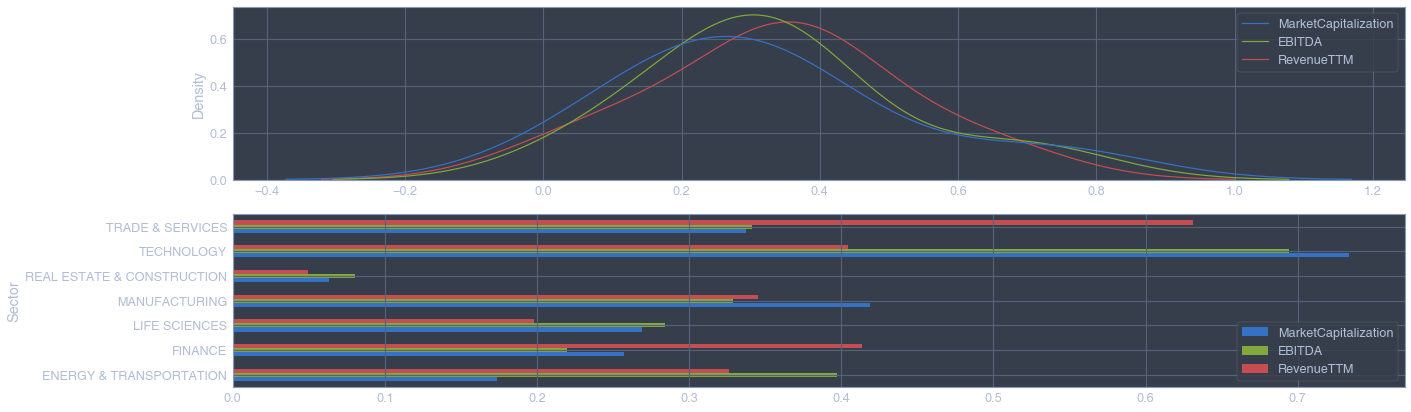

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(21, 7))
sns.kdeplot(data=df_norm, ax=ax[0])
df_norm.plot(kind='barh', ax=ax[1])

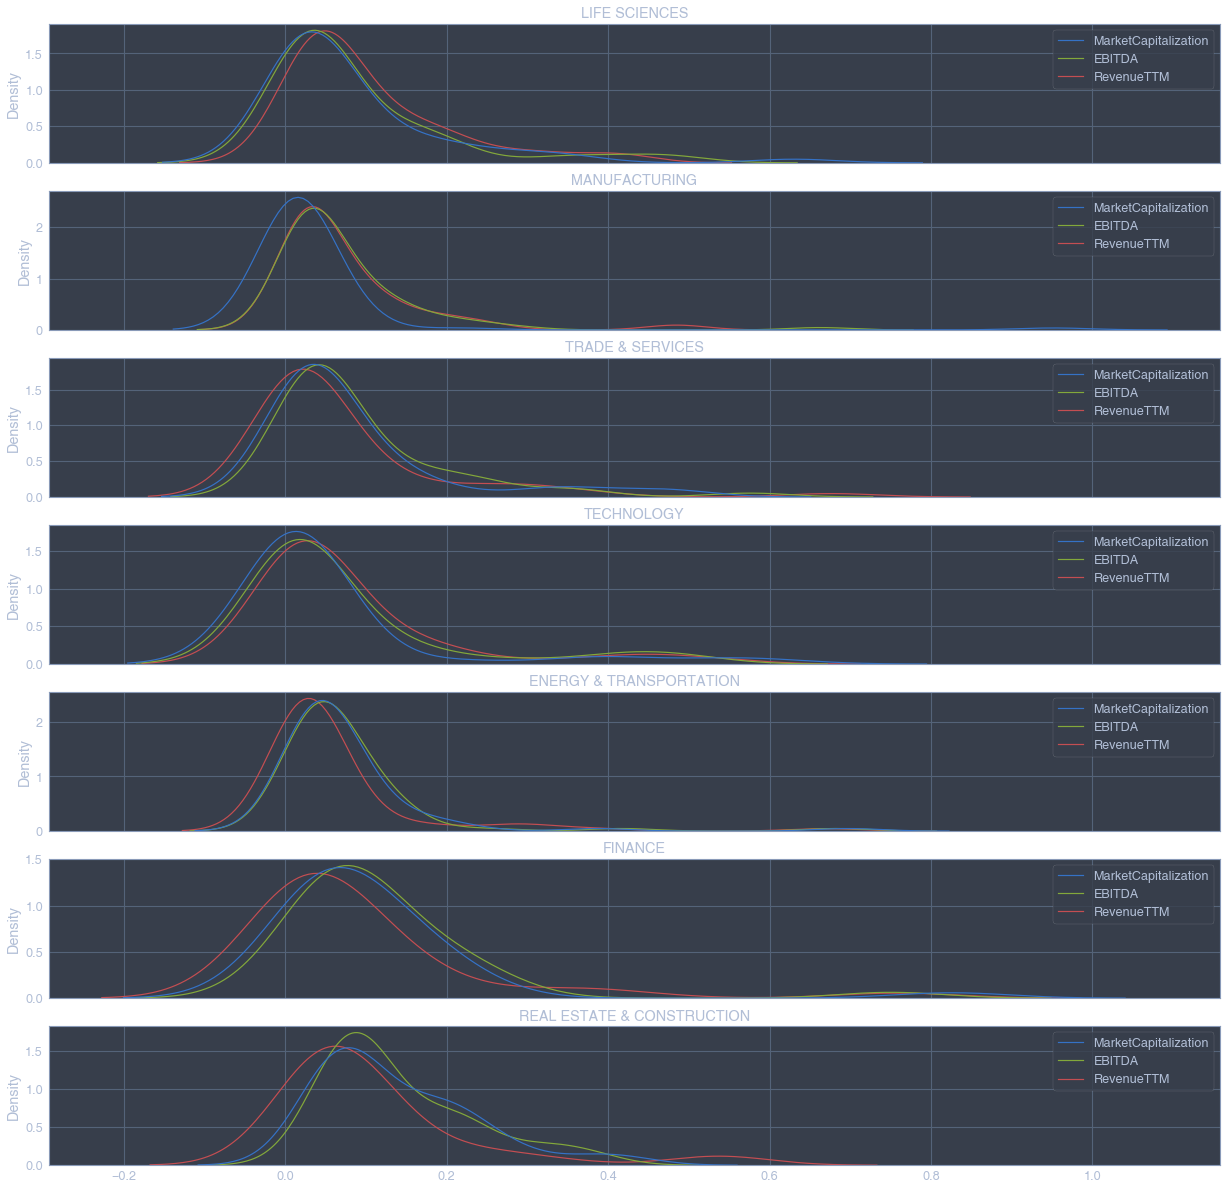

In [8]:
fig, ax = plt.subplots(7, 1, figsize=(21, 21), sharex=True)

for i, s in enumerate(data['Sector'].unique()):
    sector = data[data['Sector']==s].dropna()

    mc_norm = preprocessing.normalize(sector['MarketCapitalization'].to_numpy().reshape(1, -1))
    eb_norm = preprocessing.normalize(sector['EBITDA'].to_numpy().reshape(1, -1))
    rv_norm = preprocessing.normalize(sector['RevenueTTM'].to_numpy().reshape(1, -1))

    df_norm = pd.DataFrame(index=sector.index, data={'MarketCapitalization': mc_norm.flatten(),
                                                    'EBITDA': eb_norm.flatten(),
                                                    'RevenueTTM': rv_norm.flatten(),
                                                   })
    sns.kdeplot(data=df_norm, ax=ax[i]).set_title(s)


In [9]:
fig.savefig('graph.svg')